In [3]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import matplotlib.lines  as mlines
import sys
import json
import torch


from matplotlib          import rcParams
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 10})
plt.rcParams['figure.dpi'] = 150

## import own functions
sys.path.insert(1, '/STER/silkem/MACE/src/mace')
import src.mace.autoencoder  as ae
import src.mace.dataset      as ds
import src.mace.train        as tr
import src.mace.neuralODE    as nODE
import src.mace.plotting     as pl


sys.path.append('/STER/silkem/ChemTorch/src')
import rates as rate
## get species
specs, parnt, convs = rate.read_specs_file('C', 16)
specs_dict = dict()
idx_specs  = dict()
for i in range(len(specs)):
    specs_dict[specs[i]] = i
    idx_specs[i] = specs[i]

%load_ext autoreload
%autoreload 2

### Functions

In [4]:
def load_loss(loc, type):
    loss = {'total_loss'       : np.load(loc+type+'/total_loss.npy'),
            'total_mse_loss'   : np.load(loc+type+'/total_mse_loss.npy'),
            'total_rel_loss'   : np.load(loc+type+'/total_rel_loss.npy'),
            'idv_mse_loss'     : np.load(loc+type+'/idv_mse_loss.npy'),
            'idv_rel_loss'     : np.load(loc+type+'/idv_rel_loss.npy')
    }
    return loss

def load(outloc, dirname):
    loc   = outloc+dirname+'/'
    model = torch.load(loc+'nn.pt')
    trainloss = load_loss(loc,'train')
    testloss  = load_loss(loc,'test')
    # meta  = json.loads(loc+'meta.json')
    return model, trainloss, testloss


In [5]:
def plot_loss(train, test, log = True, ylim = True):

    fig = plt.figure(figsize = (10,4))
    ax1 = fig.add_subplot((111))

    lw = 1
    a = 0.5

    ## ------------- TRAINING ------------
    ## total loss
    ax1.plot(train['total_loss'    ], ls = '-', marker = '.', lw = lw, c='navy')
    ## mse loss
    ax1.plot(train['total_mse_loss'], ls = '-', marker = '.', lw = lw, c='royalblue', alpha = a)
    ## rel loss
    ax1.plot(train['total_rel_loss'], ls = '-', marker = '.', lw = lw, c='lightsteelblue', alpha = a)

    ## ------------ VALIDATING -----------
    ## total loss
    ax1.plot(test['total_loss'    ], ls = '-', marker = '.', lw = lw, c='maroon')
    ## mse loss
    ax1.plot(test['total_mse_loss'], ls = '-', marker = '.', lw = lw, c='firebrick', alpha = a)
    ## rel loss
    ax1.plot(test['total_rel_loss'], ls = '-', marker = '.', lw = lw, c='lightcoral', alpha = a)

    ## ------------ legend ----------------
    lw = 4
    l_train = mlines.Line2D([],[], color = 'blue', ls = '-' , label='train',lw = lw, alpha = 1)
    l_test  = mlines.Line2D([],[], color = 'red' , ls = '-' , label='test' ,lw = lw, alpha = 1)
    l_tot   = mlines.Line2D([],[], color = 'k'   , ls = '-' , label='total',lw = lw, alpha = 1)
    l_mse   = mlines.Line2D([],[], color = 'grey'     , ls = '-' , label='mse',lw = lw, alpha = 1)
    l_rel   = mlines.Line2D([],[], color = 'lightgrey', ls = '-' , label='rel',lw = lw, alpha = 1)
    handles = [l_train, l_test, l_tot, l_mse, l_rel]

    ## ------------ settings --------------
    if log == True:
        ax1.set_yscale('log') 

    if ylim == True:
        ax1.set_ylim([1e-3,1e1])

    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')

    ax1.grid(True, linestyle = '--', linewidth = 0.2)

    ax1.legend(handles=handles,loc = 'upper right')
    
    plt.tight_layout()

    return fig

def plot_loss_specs(train, specs, log = True, ylim = True):
    colors = mpl.cm.viridis(np.linspace(0, 1, len(specs)))

    fig = plt.figure(figsize = (10,6))
    ax1 = fig.add_subplot((111))

    ax1.set_title(specs)

    lw = 1
    a = 1

    ## ------------- TRAINING ------------
    leg_mse  = mlines.Line2D([],[], color = 'k' , ls = '-' , marker = 'x' , label='mse' ,lw = lw, alpha = 1)
    leg_rel  = mlines.Line2D([],[], color = 'k' , ls = '--', marker = '.' , label='rel' ,lw = lw, alpha = 1)
    handles = [leg_mse, leg_rel]

    for j, spec in enumerate(specs):
        i = specs_dict[spec]
        ## mse loss
        ax1.plot(train['idv_mse_loss'][:,i], ls = '-', marker = 'x', lw = lw, c=colors[j], alpha = a, label = 'mse '+spec)
        ## rel loss
        ax1.plot(train['idv_rel_loss'][:,i], ls = '--', marker = '.', lw = lw, c=colors[j], alpha = a, label = 'rel '+spec)
        ## legend
        leg  = mlines.Line2D([],[], color = colors[j] , ls = '-' , label=spec ,lw = 4, alpha = 1)
        handles.append(leg)


    if log == True:
        ax1.set_yscale('log') 

    if ylim == True:
        ax1.set_ylim([1e-10,1e1])

    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')

    ax1.grid(True, linestyle = '--', linewidth = 0.2)

    ax1.legend(handles= handles, loc = 'lower right')
    
    plt.tight_layout()

    return fig

### Loading the model and data

In [14]:
outloc  = '/STER/silkem/MACE/models/'
# dirname = '2023-11-21 16:57:22.470699'
# dirname = '2023-11-21 16:59:12.640608'
# dirname = '2023-11-21 17:02:18.944748'
# dirname = '2023-11-21 17:06:25.281999'
dirname = '2023-11-23 17:13:42.583941'


model, trainloss, testloss = load(outloc, dirname)

### Losses

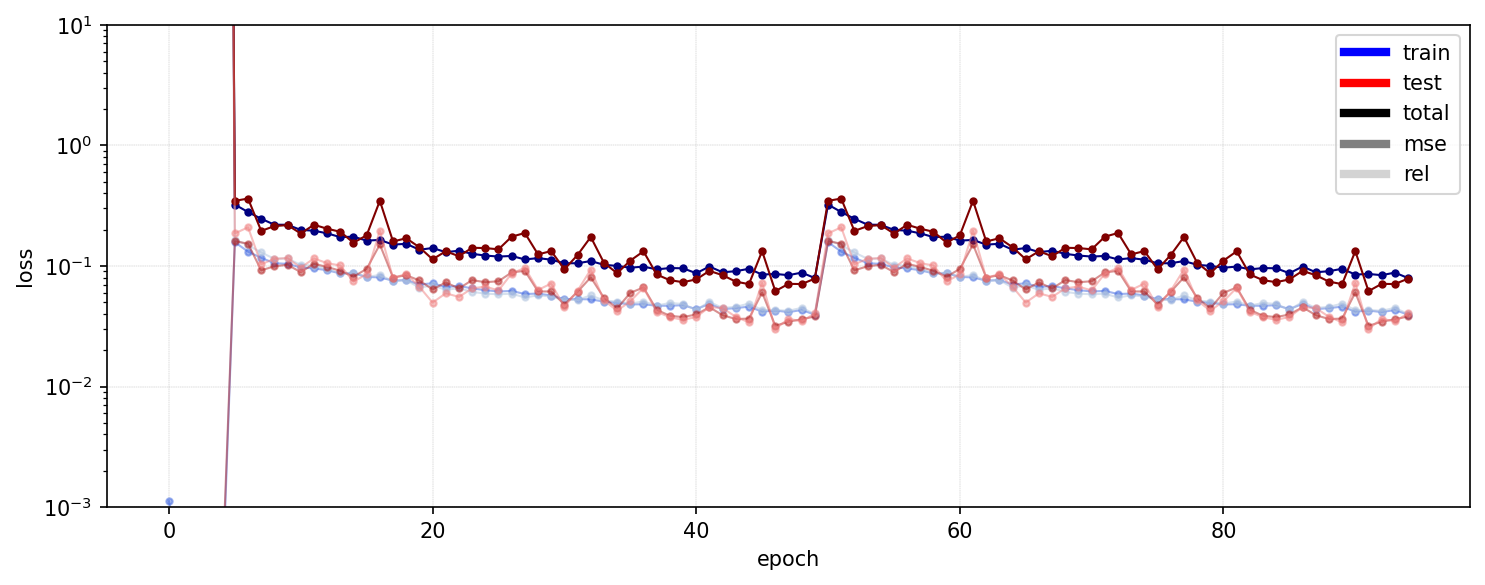

In [16]:
fig = plot_loss(trainloss, testloss, log = True, ylim = True)

plt.show()

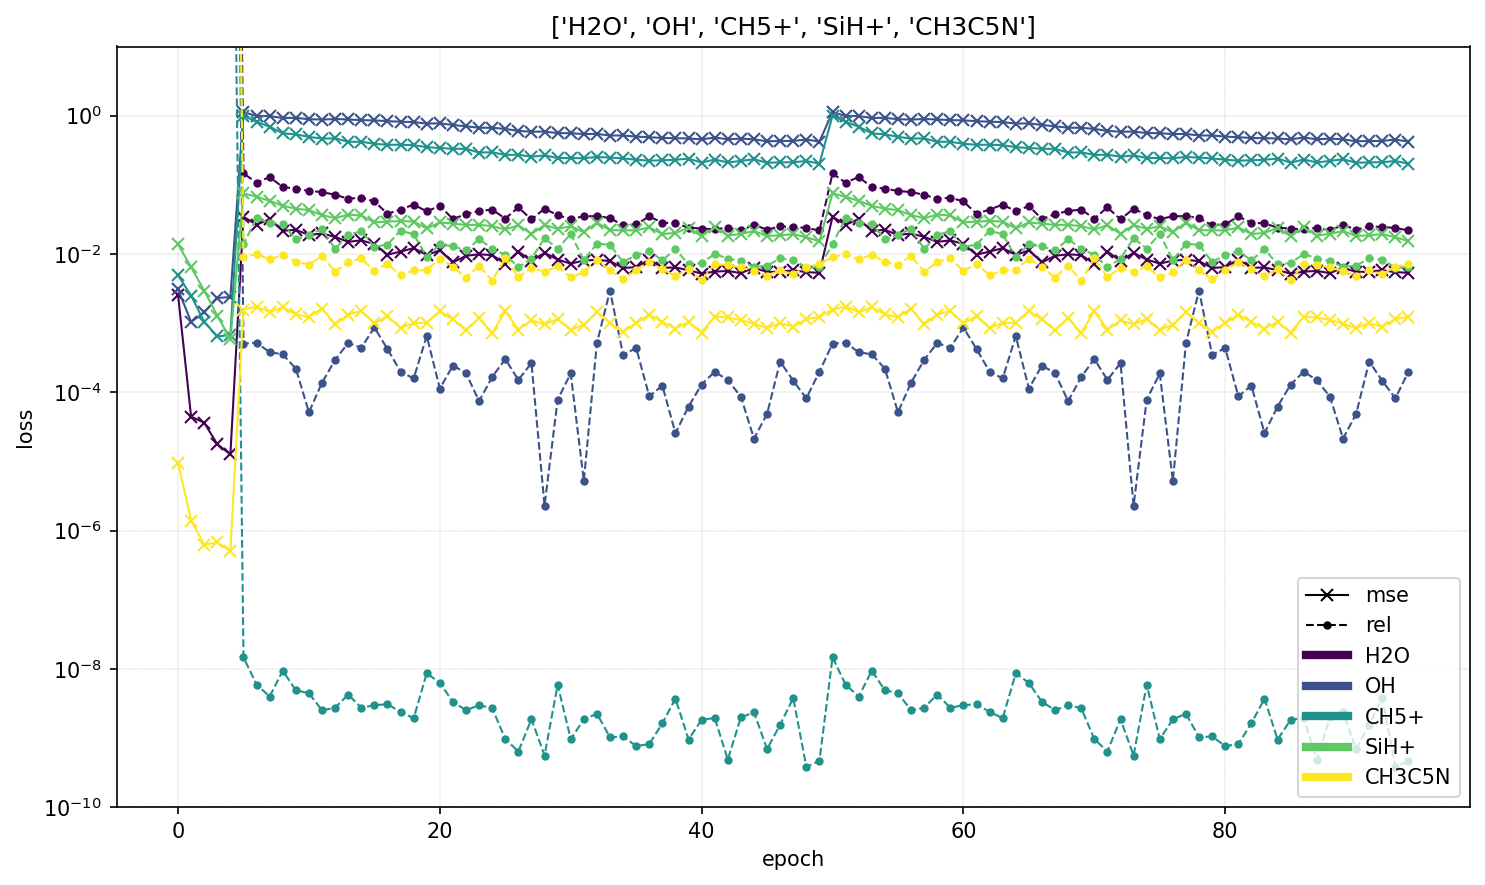

In [17]:
fig = plot_loss_specs(trainloss, ['H2O', 'OH', 'CH5+', 'SiH+','CH3C5N'], log = True, ylim = True)
plt.show()

### Test data set

In [ ]:
n_test, n_test_hat, tstep, tot_loss,mse_loss,rel_loss, mace_time = tr.test(model, test_loader, DEVICE, f_mse, f_rel)